In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
import nltk

In [2]:
# 1. Load Data
# Load the dataset
df = pd.read_csv('2 label 2.csv')

# Inspect the first few rows
print("Dataset Preview:")
print(df.head())

Dataset Preview:
   label                                              tweet
0      0   @user when a father is dysfunctional and is s...
1      0  @user @user thanks for #lyft credit i can't us...
2      0                                bihday your majesty
3      0  #model   i love u take with u all the time in ...
4      0             factsguide: society now    #motivation


In [3]:
# 2. Data Preprocessing
# Set of stopwords and Porter stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Clean the tweets
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # remove URLs
    tweet = re.sub(r'@\w+', '', tweet)  # remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # remove hashtags
    tweet = re.sub(r'\s+', ' ', tweet)  # remove extra spaces
    tweet = tweet.strip().lower()  # strip and lower case
    tokens = word_tokenize(tweet)  # tokenize
    tokens = [word for word in tokens if word.isalpha()]  # remove non-alphabetic tokens
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    tokens = [stemmer.stem(word) for word in tokens]  # stemming
    return ' '.join(tokens)

# Clean the tweets
df['cleaned_tweet'] = df['tweet'].apply(clean_tweet)

# Check cleaned tweets
print("Cleaned Tweets Preview:")
print(df[['tweet', 'cleaned_tweet']].head())

# Prepare features and labels
X = df['cleaned_tweet'].values
y = df['label'].values

Cleaned Tweets Preview:
                                               tweet  \
0   @user when a father is dysfunctional and is s...   
1  @user @user thanks for #lyft credit i can't us...   
2                                bihday your majesty   
3  #model   i love u take with u all the time in ...   
4             factsguide: society now    #motivation   

                                       cleaned_tweet  
0          father dysfunct selfish drag kid dysfunct  
1  thank credit ca use caus offer wheelchair van pdx  
2                                     bihday majesti  
3                                 love u take u time  
4                                  factsguid societi  


In [4]:
# 3. Data Splitting
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# 4. Apply Random Oversampling for hate tweets with specific sampling_strategy
desired_hate_ratio = 1.5  # Example: increase hate tweets of the dataset

# Count the number of non-hate tweets in the training set
num_non_hate_tweets = np.sum(y_train == 0)

# Calculate the desired number of hate tweets based on the desired ratio
desired_num_hate_tweets = int(desired_hate_ratio * num_non_hate_tweets)

# Ensure the desired number of hate tweets is greater than or equal to the original number of hate tweets
original_num_hate_tweets = np.sum(y_train == 1)
if desired_num_hate_tweets < original_num_hate_tweets:
    desired_num_hate_tweets = original_num_hate_tweets

# Instantiate RandomOverSampler with the desired ratio for hate tweets
oversampler = RandomOverSampler(sampling_strategy={1: desired_num_hate_tweets}, random_state=42)

# Perform oversampling on the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train.reshape(-1, 1), y_train)

In [6]:
# 5. Model Implementation
# Naive Bayes Implementation
from collections import defaultdict

#NaiveBayesModel Class
#init Method
class NaiveBayesModel:
    def __init__(self, trainUniqueData):
        self.classes = trainUniqueData

    #BagOfWord Method
    def BagOfWord(self, example, dict_index):
        if isinstance(example, np.ndarray): 
            example = example[0]
        for token_word in example.split():
            self.bow_dicts[dict_index][token_word] += 1

    
    #Training Method
    #Method Definition
    def training(self, dataset, labels):

        #Initialize Variables
        self.examples = dataset
        self.labels = labels
        self.bow_dicts = np.array([defaultdict(lambda: 0) for _ in range(self.classes.shape[0])])

        #Convert to NumPy Arrays if Necessary
        if not isinstance(self.examples, np.ndarray): 
            self.examples = np.array(self.examples)
        if not isinstance(self.labels, np.ndarray): 
            self.labels = np.array(self.labels)

        #Create Bag-of-Words Dictionaries
        for tmp_data, concat in enumerate(self.classes):
            concat_ex = self.examples[self.labels == concat]
            cleaned_examples = [clean_tweet(tmpConcat) for tmpConcat in concat_ex]
            cleaned_examples = pd.DataFrame(data=cleaned_examples)
            np.apply_along_axis(self.BagOfWord, 1, cleaned_examples, tmp_data)

        #Calculate Class Probabilities and Vocabulary
        prob_classes = np.empty(self.classes.shape[0])
        tmp_teks = []
        count_concat = np.empty(self.classes.shape[0])

        for tmp_data, concat in enumerate(self.classes):
            prob_classes[tmp_data] = np.sum(self.labels == concat) / float(self.labels.shape[0])
            count = list(self.bow_dicts[tmp_data].values())
            count_concat[tmp_data] = np.sum(np.array(list(self.bow_dicts[tmp_data].values()))) + 1
            tmp_teks += self.bow_dicts[tmp_data].keys()

        #Store Vocabulary and Class Information
        self.vocab = np.unique(np.array(tmp_teks))
        self.vocab_length = self.vocab.shape[0]
        denoms = np.array([count_concat[tmp_data] + self.vocab_length + 1 for tmp_data, concat in enumerate(self.classes)])
        self.concat_find = [(self.bow_dicts[tmp_data], prob_classes[tmp_data], denoms[tmp_data]) for tmp_data, concat in enumerate(self.classes)]
        self.concat_find = np.array(self.concat_find)

    
    #mProbability Method
    def mProbability(self, test_example):  #Method Definition:
        prob = np.zeros(self.classes.shape[0]) #Initialize Probability Array:
        for tmp_data, concat in enumerate(self.classes):#Calculate Log-Probabilities for Each Class:
            for test_token in test_example.split():
                countTest = self.concat_find[tmp_data][0].get(test_token, 0) + 1
                ProbTest = countTest / float(self.concat_find[tmp_data][2])
                prob[tmp_data] += np.log(ProbTest)

        #Combine with Prior Probabilities
        TmpProb = np.empty(self.classes.shape[0])
        for tmp_data, concat in enumerate(self.classes):
            TmpProb[tmp_data] = prob[tmp_data] + np.log(self.concat_find[tmp_data][1])
  
        return TmpProb #Return Final Probabilities:

    #Testing Method
    def testing(self, test_set):
        pred = []
        for example in test_set:
            preprocessing = clean_tweet(example)
            TmpProb = self.mProbability(preprocessing)
            pred.append(self.classes[np.argmax(TmpProb)])
        return np.array(pred)

# Train the Naive Bayes classifier on resampled data
nb_model = NaiveBayesModel(np.unique(y_train_resampled))
nb_model.training(X_train_resampled.flatten(), y_train_resampled)

In [7]:
# 6. Model Evaluation
# Predicting the test set results
y_pred = nb_model.testing(X_test)

# Evaluation metrics
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.8268418582824965
Precision: 0.9252088065940975
Recall: 0.8268418582824965
F1 Score: 0.8622823338301437


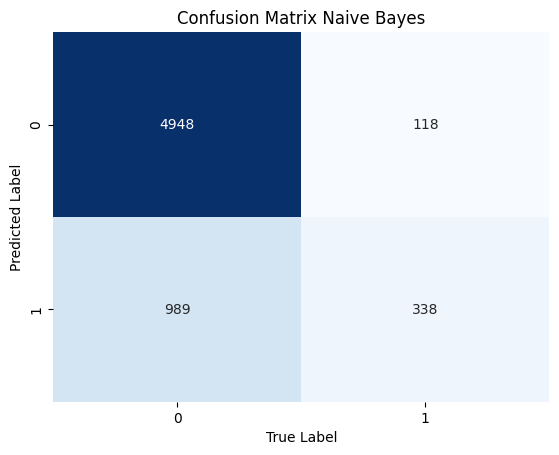

In [8]:
# 7. Visualization
# 7.1 Confusion Matrix
plt.figure(dpi=100)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.title('Confusion Matrix Naive Bayes')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

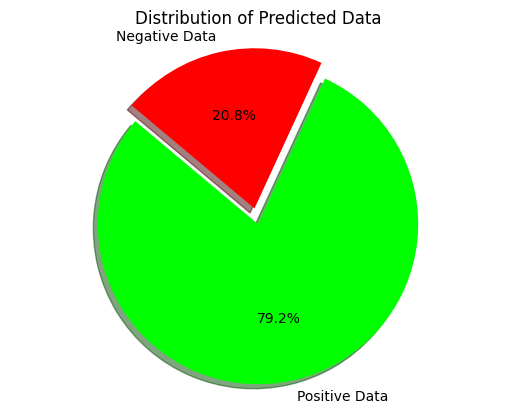

In [9]:
# 7.2 Pie Chart for Distribution of Positive vs Negative Data
data_positive = np.count_nonzero(y_pred == 0)
data_negative = np.count_nonzero(y_pred == 1)

# Data to plot
labels = ['Positive Data', 'Negative Data']
sizes = [data_positive, data_negative]
colors = ['lime', 'red']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Distribution of Predicted Data')
plt.show()

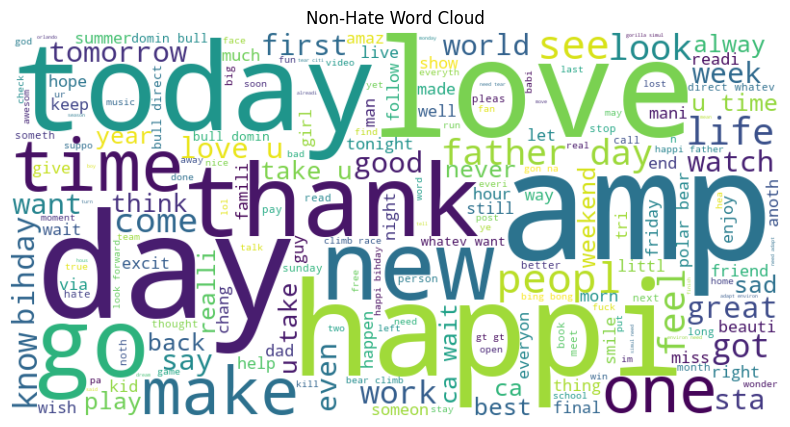

In [10]:
# 7.3 Word Clouds
# Generate word cloud for Non-Hate Words
non_hate_words = ' '.join(df[df['label'] == 0]['cleaned_tweet'])
wordcloud_non_hate = WordCloud(width=800, height=400, background_color='white').generate(non_hate_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_hate, interpolation='bilinear')
plt.title('Non-Hate Word Cloud')
plt.axis('off')
plt.show()

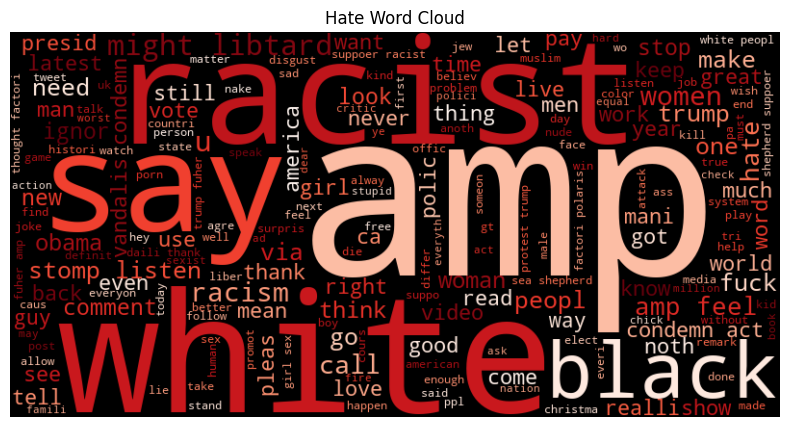

In [11]:
# Generate word cloud for Hate Words
hate_words = ' '.join(df[df['label'] == 1]['cleaned_tweet'])
wordcloud_hate = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(hate_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_hate, interpolation='bilinear')
plt.title('Hate Word Cloud')
plt.axis('off')
plt.show()

In [12]:
# 7.4 Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      5937
           1       0.25      0.74      0.38       456

    accuracy                           0.83      6393
   macro avg       0.62      0.79      0.64      6393
weighted avg       0.93      0.83      0.86      6393



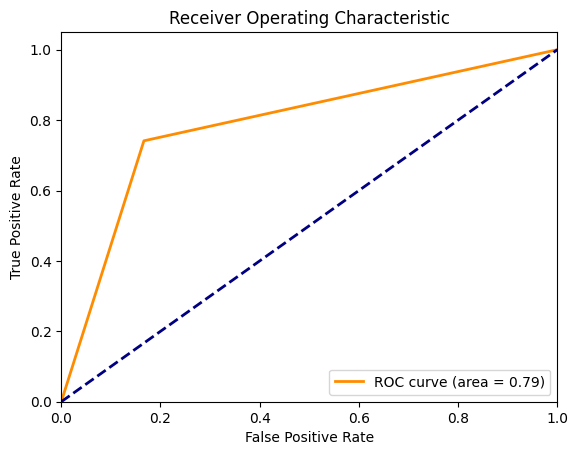

In [13]:
# 7.5 ROC Curve and AUC Score
from sklearn.preprocessing import label_binarize

# Binarize the output labels for ROC curve computation
y_test_binarized = label_binarize(y_test, classes=[0, 1]).ravel()

# Get prediction probabilities for the hate class (label 1)
y_prob = nb_model.testing(X_test)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test_binarized, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# 8.0 Create GUI
import tkinter as tk
from tkinter import messagebox

def predict_tweet():
    tweet = entry.get()
    # Check for non-alphabetic characters
    if not tweet.replace(" ", "").isalpha():
        messagebox.showerror("Input Error", "Please enter a tweet containing only alphabetic characters.")
        return
    prediction = nb_model.testing([tweet])[0]
    probability = np.max(nb_model.mProbability(clean_tweet(tweet)))
    if prediction == 1:
        result = "Hate Tweet"
    else:
        result = "Non-Hate Tweet"
    messagebox.showinfo("Prediction", f"Prediction: {result}")

root = tk.Tk()
root.title("Hate Tweet Classifier")
label = tk.Label(root, text="Enter tweet text here")
label.pack()
entry = tk.Entry(root, width=50)
entry.pack()
button = tk.Button(root, text="Predict", command=predict_tweet)
button.pack()
root.mainloop()